### To address the problem, we need to consider the following points:

#### 1. How can we extract text from a PDF?
#### 2. Does the text get distorted when reading the PDF?
#### 3. How can we handle footers that divide words?

#### To tackle these problems, I used the `pypdf` library to read the PDF and extract text from it. Additionally, I implemented custom functions to separate footers, headers and handle the new line characters `\n` as well as the word seperation `-\n` from the main text.

#### After text cleaning, I used the `NLTK` library to split the text into sentences to facilitate entity extraction. However I noticed that the first 11 and last 4 pages are formatted differently then the rest of the file. And the extracted sentences would lead to confusion hence I removed them.

#### Since reading text from PDFs can introduce irregularities, I applied an auto-correction method to smooth the sentences, making them more readable.

#### Once the text was cleaned and segmented, I used regular expressions (`regex`) to extract entities from the text.

#### However, this method has certain drawbacks. For instance, I used regex to determine the footnotes, and assumed that first line of the page consists of the title and the page number thus ignored the first and last pages in the document, applying this approach to a large set of PDFs may result in the loss of important content in the first pages. Thus, I recommend either avoiding the deletion of the pages or implementing a method to detect them automatically.

#### Additionally, I believe using `regex` for entity extraction is not the most efficient method, as certain entities like "consiglio" and "camera(e)" may have meanings other than the ones we are looking for. To improve the extraction process, I suggest using a more advanced approach such as fine-tuning a BERT model or using `Spacy` to extract the entities by performing a `Named Entity Recognition (NER)`.

#### In the process, I tried to use Spacy for entity extraction to select the ORG entities however it sometimes had issues differentiating between camera and camera dei deputati. Example: even the word was camera dei deputati, it was selecting the camera as the entity. Thus, I decided to use regex for the entity extraction.

#### For the bonus part of the task, I completely seperated all the fotenotes that exist in the pdf into a dictionary page by page but I couldn't make sure what are the asked references and their formatting.

##### P.S. I have used Python 3.10.0 for this notebook.

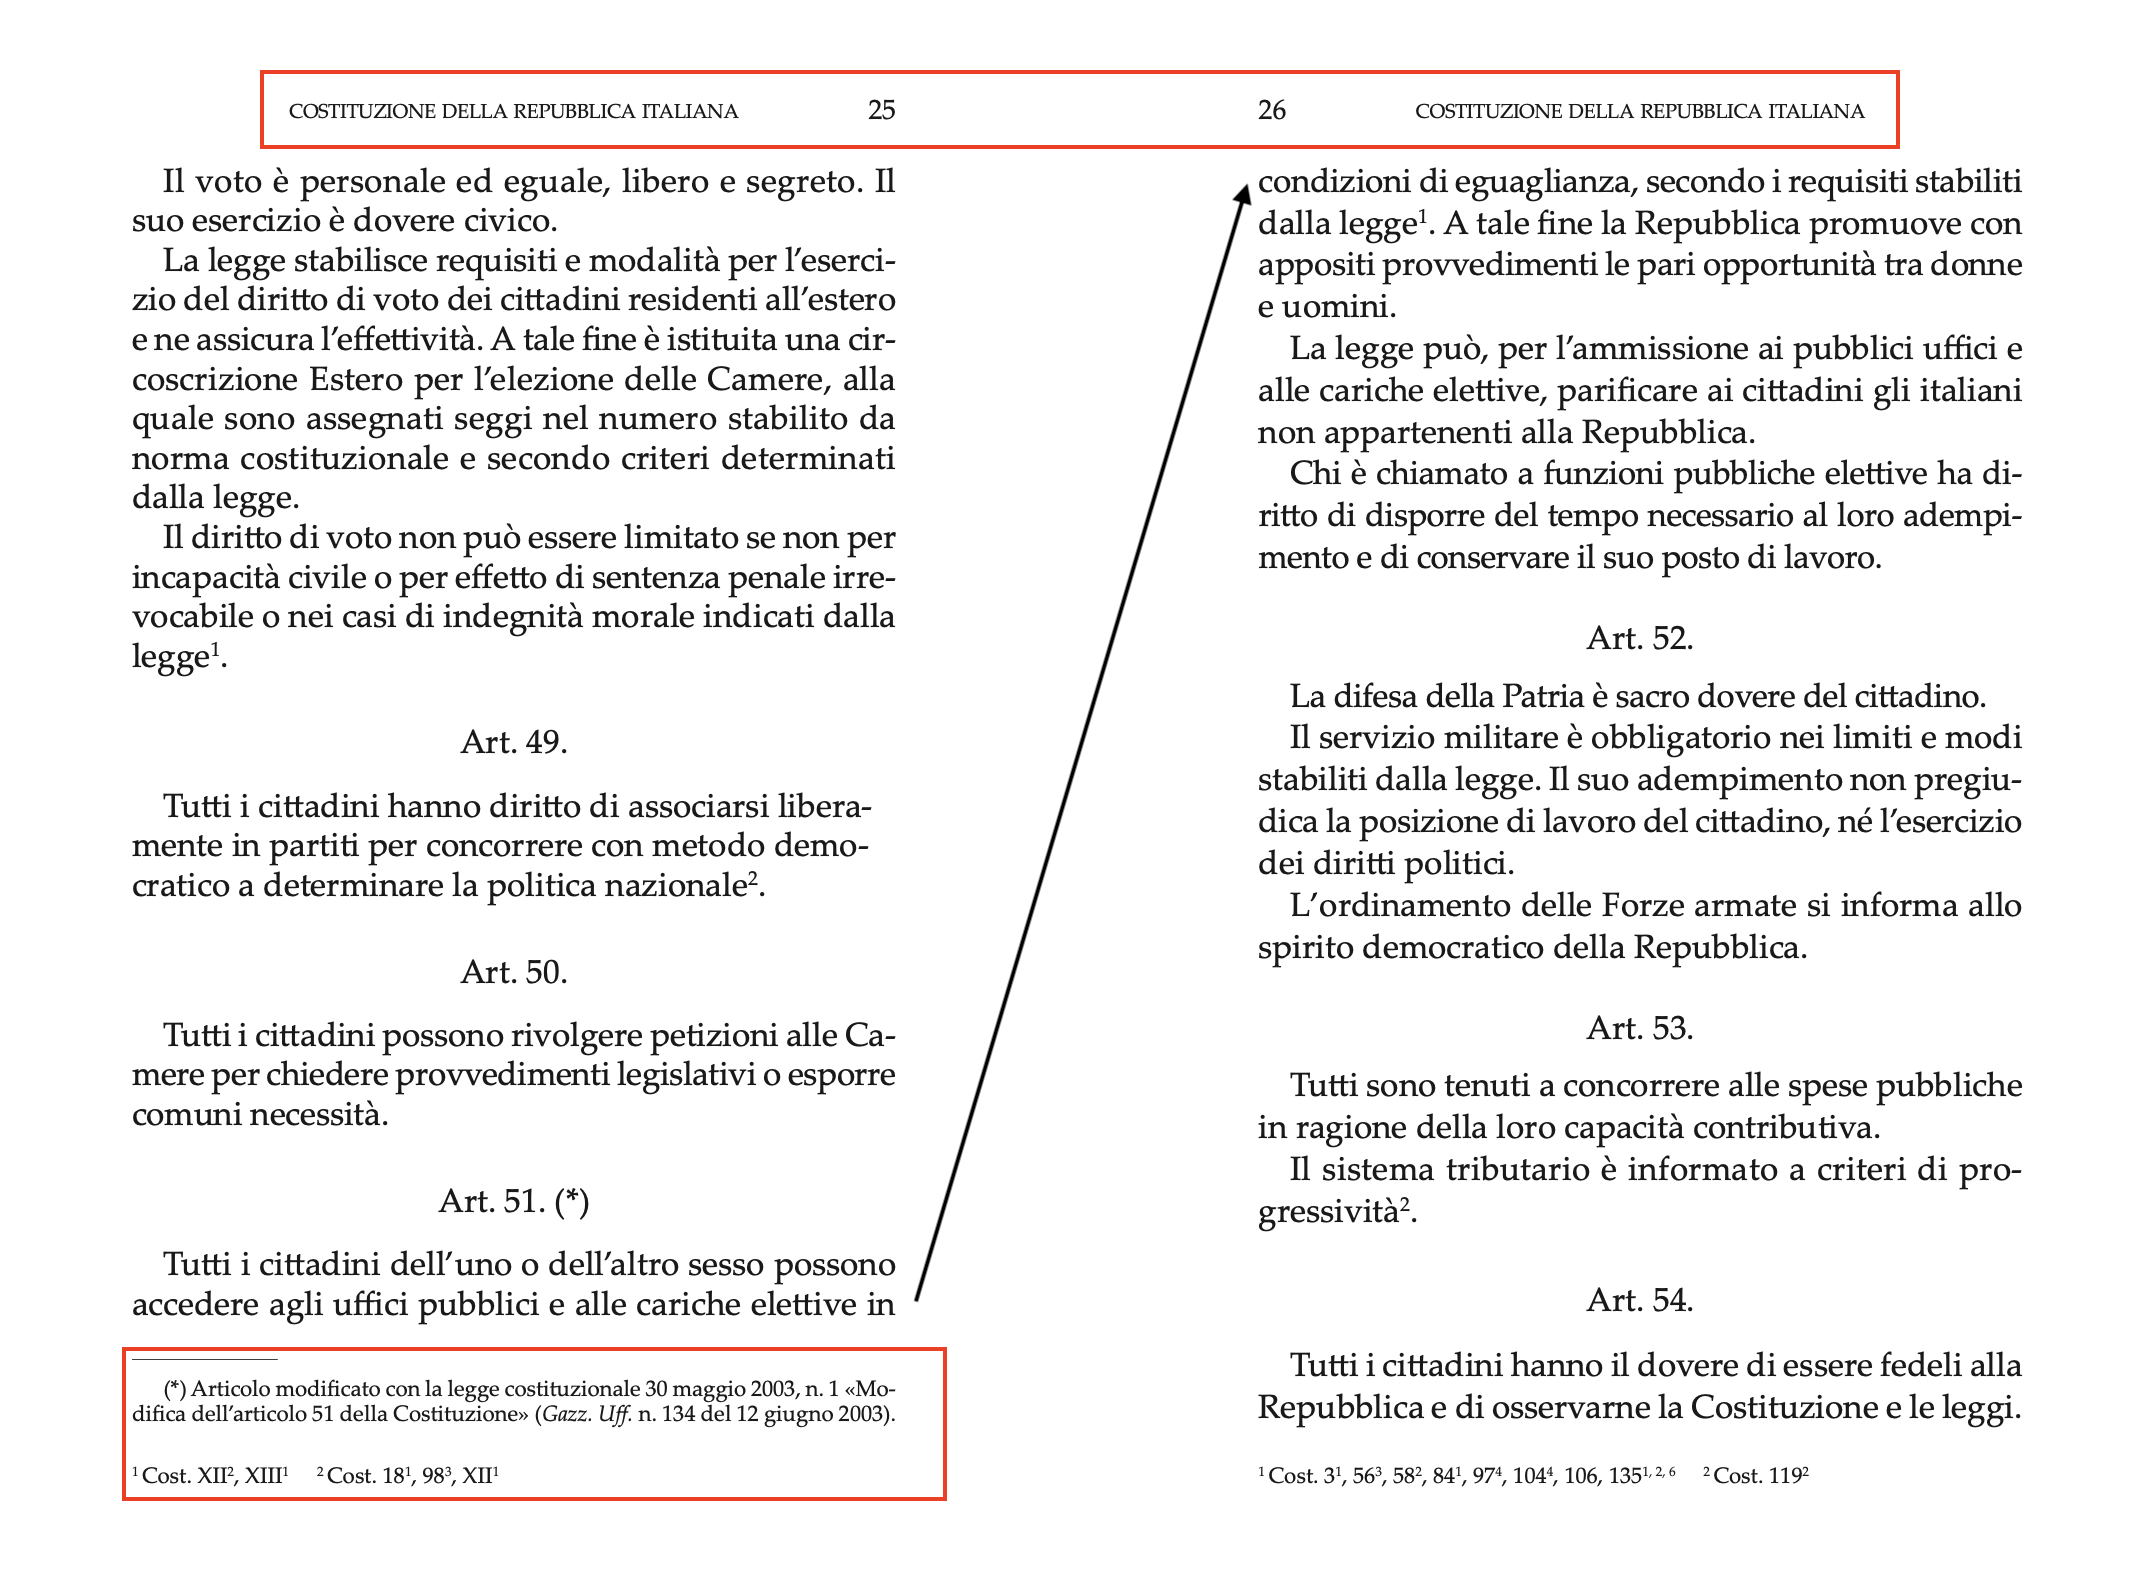

In [15]:
from IPython.display import Image
Image(filename="Screenshot 2024-09-26 at 16.28.23.png")

In [32]:
!pip install nltk
!pip install language_tool_python
!pip install pypdf

  Obtaining dependency information for language_tool_python from https://files.pythonhosted.org/packages/90/49/df8fb36e130f3eafe1e702c852edfd03fbac1ff6d7a79e623f617ee73f46/language_tool_python-2.8.1-py3-none-any.whl.metadata
  Obtaining dependency information for pypdf from https://files.pythonhosted.org/packages/48/8f/9bbf22ba6a00001a45dbc54337e5bbbd43e7d8f34c8158c92cddc45736af/pypdf-5.0.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.5/294.5 kB 5.7 MB/s eta 0:00:00a 0:00:01


I first started by importing the necessary libraries.

In [16]:
import re
import nltk
import language_tool_python
from pypdf import PdfReader

The custom function that I created to detect the footnotes as they either start with (*) or with Cost. I used this function to separate the footnotes from the main text.

In [17]:
# Function to detect footnotes, including (*) patterns and "number Cost. number" patterns
def detect_footnotes(text):
    lines = text.split("\n")
    footnotes = []
    
    footnote_pattern = re.compile(r"^\(\*\)|^\d+ Cost\.\s\d+|^\d+\.")
    
    # Find the index of the first footnote
    for i, line in enumerate(lines):
        if footnote_pattern.match(line.strip()):
            footnotes.append(line.strip())
            return i, footnotes  # Return index of first footnote and the footnote list
    
    return None, footnotes

# Function to clean the content and detect footnotes
def clean_and_detect_footnotes(text):
    lines = text.split("\n")
    
    # Detect the first footnote and get its index
    footnote_index, footnotes = detect_footnotes(text)
    
    # If a footnote is found, truncate text from the first footnote onward
    if footnote_index is not None:
        lines = lines[:footnote_index]  # Remove everything from footnote onward
    
    # Remove first line (assumed to be title) and last line (assumed to be page number)
    if len(lines) > 2:
        lines = lines[1:-1]  # Remove the top and bottom lines
    
    # Re-join lines to get cleaned text
    cleaned_text = "\n".join(lines)
    
    # Replace hyphenated line breaks and normal line breaks
    cleaned_text = cleaned_text.replace("-\n", "").replace("\n", " ")

    return cleaned_text, footnotes

As some words had numbers at the end of the line, I created a custom function to handle these cases.

In [18]:
# Function to remove numbers from words like "Paese1", "centramento3"
def remove_numbers_from_words(text):
    # Use regex to remove digits that are attached to letters (e.g., Paese1 -> Paese, centramento3 -> centramento)
    cleaned_text = re.sub(r'([a-zA-Z]+)\d+', r'\1', text)
    return cleaned_text

A custom function that reads the pdf and concatenates it into a single string.

In [19]:
# Function to read PDF and concatenate pages, handling footnotes and hyphenated words
def read_pdf_with_concatenation(pdf_path):
    pdf_text = ""
    footnotes_dict = {}
    reader = PdfReader(pdf_path)
    
    previous_page_ends_with_hyphen = False
    
    for page_num in range(11,len(reader.pages)-4):
        page = reader.pages[page_num]
        # Extract text from the page
        page_text = page.extract_text()

        if page_text:
            # Clean text and detect footnotes
            cleaned_text, footnotes = clean_and_detect_footnotes(page_text)
            
            # Handle hyphenation at the end of the previous page
            if previous_page_ends_with_hyphen:
                pdf_text += cleaned_text.strip()  # Concatenate without space
            else:
                pdf_text += " " + cleaned_text.strip()  # Add space between pages

            # Check if the current page ends with a hyphen
            previous_page_ends_with_hyphen = cleaned_text.endswith("-")
            
            # Store footnotes in a separate dictionary with page number as key
            if footnotes:
                footnotes_dict[page_num + 1] = footnotes

    # After concatenating pages, remove numbers from words
    pdf_text = remove_numbers_from_words(pdf_text)

    return pdf_text.strip(), footnotes_dict


As reading from the pdf may disort the text, I used autocorrect to smooth the sentences. I used language tool python library to correct the sentences.

In [20]:
# Initialize the language tool for Italian
tool = language_tool_python.LanguageTool('it')

# Function to apply auto-correction to a sentence using language_tool_python
def autocorrect_sentence(sentence):
    # Use the language tool to find and apply corrections
    matches = tool.check(sentence)
    corrected_sentence = language_tool_python.utils.correct(sentence, matches)
    return corrected_sentence


I used the nltk library to split the text into sentences.

In [21]:
# Download the punkt tokenizer from nltk if not already present
nltk.download('punkt')


# Function to clean, protect patterns, and split into sentences
def split_into_sentences_protected(text):
    # Step 1: Tokenize sentences using nltk
    sentences = nltk.sent_tokenize(text)
        
    # Step 2: Apply auto-correction to each sentence
    corrected_sentences = [autocorrect_sentence(sentence) for sentence in sentences]
    
    return corrected_sentences


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


I generated the corrected sentences using the function defined above.

In [22]:
# Path to your PDF file
pdf_path = "Costituzione_ITALIANO.pdf"

# Read PDF and concatenate text
concatenated_text, footnotes_dict = read_pdf_with_concatenation(pdf_path)

# Split concatenated content into sentences, protecting patterns, and apply auto-correction
corrected_sentences = split_into_sentences_protected(concatenated_text)


To see how the text looks like after cleaning, I printed sentences.

In [23]:
# Example: Print the first few corrected sentences
print(f"Corrected Sentences after processing:\n")
for i, sentence in enumerate(corrected_sentences, 1):
    print(f"{i}. {sentence}")

# Example: Print footnotes on certain pages
if footnotes_dict:
    print(f"\nFootnotes detected on these pages: {list(footnotes_dict.keys())}")
else:
    print("\nNo footnotes detected.")

Corrected Sentences after processing:

1. La libertà e l’eguaglianza dei cittadini, impediscono il pieno sviluppo della persona umana e l’e Bettina partecipazione di tutti i lavoratori all’organizzazione po litica, economica e sociale del Paese.
2. Art.
3. 4.
4. La Repubblica riconosce a tutti i cittadini il diritto al lavoro e promuove le condizioni che rendano e Bettino questo diritto.
5. Ogni cittadino ha il dovere di svolgere, secondo le proprie possibilità e la propria scelta, una attività o una funzione che concorra al progresso materiale o spirituale della società.
6. Art.
7. 5.
8. La Repubblica, una e indivisibile, riconosce e pro muove le autonomie locali; attua nei servizi che dipendono dallo Stato il più ampio decentramento amministrativo; adegua i principi e i metodi della sua legislazione alle esigenze dell’autonomia e del decentramento.
9. Art.
10. 6.
11. La Repubblica tutela con apposite norme le minoranze linguistiche.
12. Art.
13. 7.
14. Lo Stato e la Chiesa cattolica 

In [24]:
for footnotes_i in footnotes_dict:
    footnotes_dict[footnotes_i] = autocorrect_sentence(footnotes_dict[footnotes_i])

Then I used regex to extract entities from the text. First I created a dictionary of the search terms.

In [25]:
import json
import re

Creating the dictionary, I also added the plural forms of the words to be able extract them as well and saved them under the same key.

In [26]:
# Define the list of terms with IRI and labels
search_terms = [
    {"iri": "camera_deputati", "labels": ["Camera dei Deputati", "Camera", "Camere"]},
    {"iri": "senato_repubblica", "labels": ["Senato della Repubblica", "Senato"]},
    {"iri": "presidente_repubblica", "labels": ["Presidente della Repubblica"]},
    {"iri": "governo", "labels": ["Governo"]},
    {"iri": "regione", "labels": ["Regione","Regioni"]},
    {"iri": "parlamento", "labels": ["Parlamento"]},
    {"iri": "consiglio_superiore_magistratura", "labels": ["Consiglio superiore della magistratura", "Consiglio"]}
]

I created a search function to use regex to extract entities from the text by using the dictionary created above.

In [27]:
# Function to search for terms in sentences and store information in JSON format
def search_terms_in_sentences(sentences):
    results = []
    
    for sentence in sentences:
        matched_spans = []  # Keep track of spans to avoid duplicates
        
        # For each search term, check if any of the labels are in the sentence
        for term in search_terms:
            for label in term["labels"]:
                # Use regex to find the term in a case-insensitive manner
                matches = re.finditer(r'\b' + re.escape(label) + r'\b', sentence, re.IGNORECASE)
                
                for match in matches:
                    start, end = match.span()
                    
                    # Check if the span is already matched
                    if not any(existing_start <= start < existing_end for existing_start, existing_end in matched_spans):
                        # Add the span to the list of matched spans
                        matched_spans.append((start, end))
                        
                        # Create the result object
                        result = {
                            "iri": term["iri"],
                            "label": label,
                            "span_start": start,
                            "span_end": end,
                            "sentence": sentence
                        }
                        results.append(result)
    
    return results

I ran the function to extract entities from the text and saved them as an output file.

In [28]:
# Search for terms in the list of sentences
json_results = search_terms_in_sentences(corrected_sentences)

# Write the results to a JSON file
output_file_path = "search_results.json"
with open(output_file_path, 'w', encoding='utf-8') as json_file:
    json.dump(json_results, json_file, ensure_ascii=False, indent=4)

print(f"Results have been written to {output_file_path}")


Results have been written to search_results.json


In [29]:
footnotes_dict

{12: '1 Cost. 343     2 Cost. 118     3 Cost. 114 e segg., IX      4 Cost. 31, XCostituzione della Repubblica Italiana_Layout 1  17/10/2023  08:12  Pagina 9Cast Cast Castsega CastCostituzione   ',
 13: '(*) Articolo modi ﬁcato con la legge costituzionale 11 febbraio 2022, n. 1 «Mo -Acate',
 14: '(*) V. anche la legge costituzionale 21 giugno 1967, n. 1 «Estradizione per i',
 15: '1 Cost. 1116, 7     2 Cost. 142, 253     3 Cost. 273 Costituzione della Repubblica Italiana_Layout 1  17/10/2023  08:12  Pagina 12Cast Cast Cast   ',
 16: '1 Cost. 132, 1116     2 Cost. 1116     3 Cost. 1 201, XIII2     4 Cost. 354Costituzione della Repubblica Italiana_Layout 1  17/10/2023  08:12  Pagina 13Cast Cast Cast Cast   ',
 17: '1 Cost. 19, 20, 391, 49     2 Cost. 31, 8, 181, 20     3 Cost. 8, 181, 19     4 Cost. 1116Costituzione della Repubblica Italiana_Layout 1  17/10/2023  08:12  Pagina 14Cast Cast Cast Cast   ',
 18: '1 Cost. 31     2 Cost. 1031, 1131Costituzione della Repubblica Italiana_Layout 1